# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/) off the coast of New England. This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop. Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components. Topics include:

* [Expanding the control state vector](#capturing-flywheel-motions)
* [Custom PTO physics](#manually-defining-pto-equations)
* [Modeling non-hydrodynamic degrees of freedom](#flywheel-residual-equation)
<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="307"></p>

In [1]:
import os
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

import wecopttool as wot
wot.set_loglevel("INFO")
## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with the setting up the different waves we want to model because this will inform our frequency array, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site. The regular wave is roughly at the pitch resonance frequency of the buoy which is known to be about 0.35 Hz.

In [2]:
f1 = 0.05 # Hz
nfreq = 75

In [3]:
amplitude = 0.15
wavefreq = 0.35
waves_regular = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)

### 1.2 Basic properties
#### Geometry
To get the required hydrodynamic coefficients of the Pioneer design, we only need to be concerned with creating a mesh of the buoy geometry. The buoy has the same general shape as the WaveBot used in Tutorial 1, so we will use the build-in `geom.WaveBot` object and change the dimensions to simplify the mesh creation process.

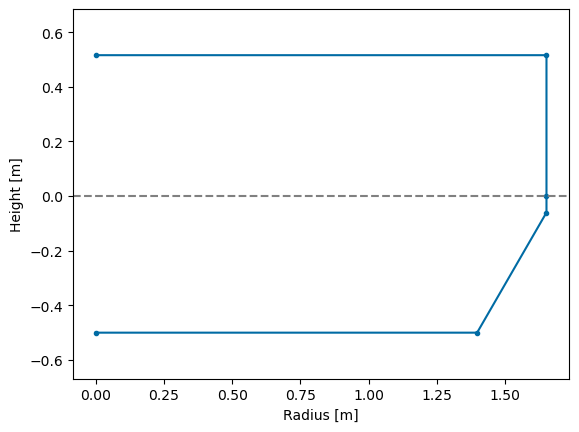

In [4]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.5)
_ = hull_geom.plot_cross_section()

#### Design properties
The Pioneer team has developed initial specifications for a full-sized WEC design that fits within the buoy dimensions and operating at resonance. There are several components that we need to capture in the PTO model:

* **Buoy**: As mentioned, this has the same basic geometric parameters as the WaveBot used in Tutorial 1. Since we're only modeling the pitch degree of freedom, we only need the pitch moment of inertia and not the mass of the buoy.
* **Flywheel**: The flywheel is contained and dimensioned to fit on top of the buoy. It rotates (pitch) independently of the buoy but is linked to the buoy through two parallel connections: the torsional spring and the generator. Since the flywheel is protected from wave loading by the buoy, it is **not** subject to hydrostatics or hydrodynamics.
* **Spring**: The magnetic torsional spring provides positive stiffness to the flywheel. It has a linear displacement up to 45 degrees, at which point it "wraps around" and the stiffness begins decreasing. For simplicity, we will model the spring as strictly linear. The spring is connected to a gearbox which makes the posisition of the spring be different from the relative position of the flywheel and buoy (position of the genrator shaft). 

A rendering of the Pioneer WEC model is shown here with the buoy pitch in red and the flywheel pitch in green:
<p><img src=https://live.staticflickr.com/65535/53025745404_2e75c89894_k.jpg alt="Diagram of the Pioneer device" width="500"></p>

In [5]:
buoy_props = {
    'CG': 0.242, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

flywheel_props = {
    'MOI': 25,  # kg-m^2
    'Coulomb friction': 2.0,  # N-m
    'Viscous friction': 0.02,  # N-m/rad
    'Gear ratio': 3, # -
}

spring_props = {
    'Max torque': 750, # N-m
    'Max displacement': np.deg2rad(45.0), # rad
}

#### Pitch resonator
This system uses a unique PTO system, where the generator velocity is dependent on the relative pitching rotation of the buoy and the flywheel. The system can be modeled as a coupled spring-mass-damper system, with the generator represented as $B_{PTO}$. The spring-mass-damper system and equivalent circuit model are shown below. Note that all of these values are rotational and are drawn here linearly for simplicity. 

<p><img src=https://live.staticflickr.com/65535/53025028262_1a4ba2d5ce_z.jpg alt="Pioneer model as a spring-mass-damper system" width="500"><img src=https://live.staticflickr.com/65535/53025140497_29c5b9d601_z.jpg alt="Pioneer model as a spring-mass-damper system" width="180"></p>

This corresponds to the following dynamics equations:

(1) $$ [J_{buoy} + J(\omega))] \ddot{\theta}_{buoy} = T_{hydro} - K_{hydro}\theta_{buoy} - B(\omega)\dot{\theta}_{buoy} - K_{spring}N^2(\theta_{buoy} - \theta_{flywheel}) - (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

(2) $$ J_{flywheel} \ddot{\theta}_{flywheel} = K_{spring}N^2(\theta_{buoy} - \theta_{flywheel}) + (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

We will explore how to capture these dynamics in WecOptTool in the following sections.

#### Hydrodynamics and hydrostatics
As mentioned above, the `FloatingBody` object in Capytaine only needs to model the buoy, since no other components are being excited by the waves.

INFO:capytaine.io.meshio:Stored 1174 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: Pioneer.


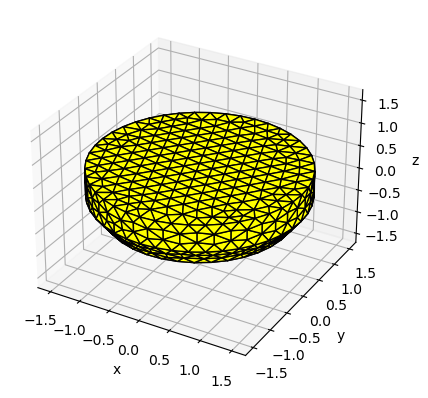

In [6]:
pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs
pnr_fb.show_matplotlib()

In [7]:
rho = 1025. # kg/m^3
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
bem_data = wot.run_bem(pnr_fb, freq)
omega = bem_data.omega.values

pnr_fb.keep_immersed_part()
k_buoy = pnr_fb.compute_hydrostatic_stiffness(rho=rho).values.squeeze()
k_spring = spring_props['Max torque'] / spring_props['Max displacement']
print(f'Hydrostatic stiffness from Capytaine: {k_buoy} N-m/rad')
print('Hydrostatic stiffness from experiment: 37204 N-m/rad')

INFO:capytaine.bodies.bodies:Clipping Pioneer_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pion

Hydrostatic stiffness from Capytaine: 40412.7656865078 N-m/rad
Hydrostatic stiffness from experiment: 37204 N-m/rad


As with previous tutorials, we will plot the hydrodynamic coefficients to confirm that we are properly capturing the full excitation range of the buoy.

Text(0.5, 1.0, 'Radiation Damping Coefficients')

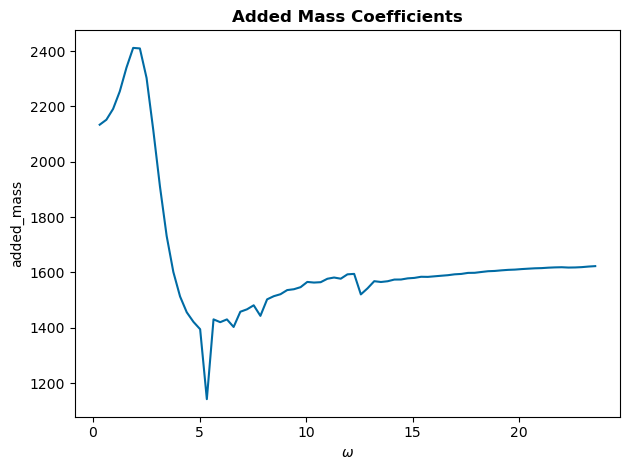

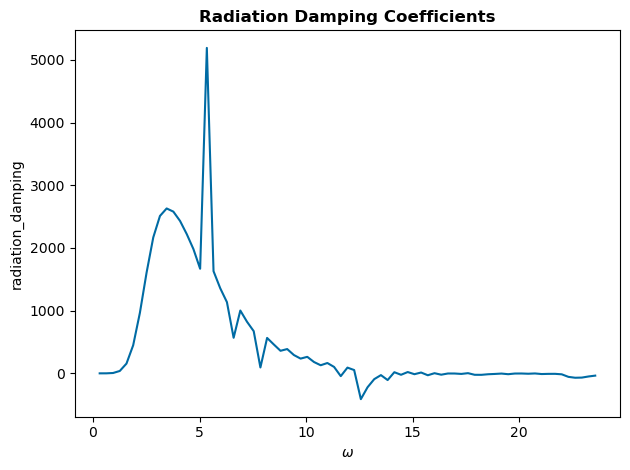

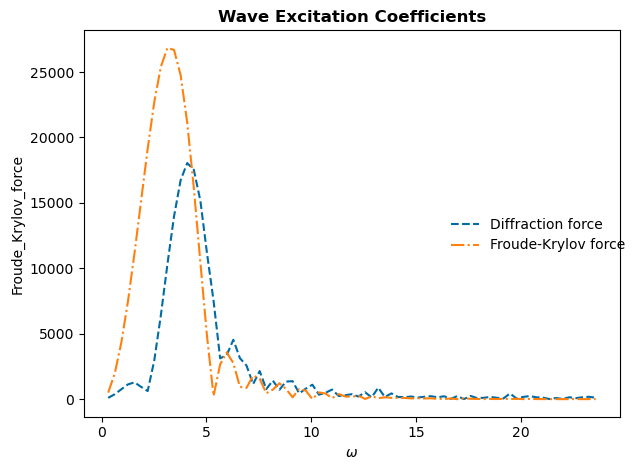

In [8]:
# Plots
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')

### 1.3 PTO
The generator shaft velocity is the difference between the buoy velocity and the flywheel velocity. Because the velocity PTO depends not only on the hydrodynamic states (`x_wec`, buoy pitch) but also on an additional non-hydrodynamic state (flywheel pitch), we cannot use the `PTO` module we have used in previous tutorials. Instead, we will make two adjustments to our model compared to previous tutorials:

1. We will adjust the `x_opt` vector to include the flywheel motion
2. We will manually define the equations for the PTO dynamics and energy equations

#### Capturing flywheel motions
In previous tutorials, all the relevant WEC dynamics have been captured in the `x_wec` vector. However, `x_wec` assumes all the degrees of freedom are excited by waves, which is not the case for the flywheel in the Pioneer model.

The `x_opt` vector has previously only been used to model the PTO force. However, there is no limit to what `x_opt` can include; it can theoretically include anything that is needed to model the PTO control. Since we need to capture the flywheel dynamics to properly model the PTO, we will append the Fourier coefficients of the flywheel's position to `x_opt`. The first part of `x_opt` will continue to be used for the PTO force (e.g. Fourier coefficients of the force time-series for an unstructured controller). 

Note in the code further down that `x_opt` will be spliced as either `x_opt[:nstate_pto]` to exclude the flywheel position states, or `x_opt[nstate_pto:]` to exclude the PTO force states. Remember, `x_opt` can be defined arbitrarily, and specific meanings to the states are given elsewhere in the model.

In [9]:
nstate_pto = 2 * nfreq # PTO forces
nstate_fw = 2 * nfreq  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

#### Manually defining PTO equations
Instead of calling the `PTO` module, we will manually define the dynamics and energy equations needed for WecOptTool to calculate electrical power, our quantity of interest for this optimization problem. These equations are also needed for the additional forces and constraints defined later on.

#### Relative motion
Here we define functions for the relative motion of the buoy and flywheel, derived from `x_wec` and `x_opt` respectively.

In [10]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_fw

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

#### Unstructured controller
This is nearly identical to the `wot.pto.controller_unstructured` function, except `x_opt` is spliced to only include the first part, since we are also including the flywheel positions in the second part of `x_opt`.

In [11]:
def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
    # gain = x_opt[:nstate_pto]
    # return gain * rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, motor)

#### PTO Impedance
The PTO impedance is defined using the same 2-port impedance model as in previous tutorials. The drivetrain inertia, friction, and stiffness are not included here since they are accounted for in the modeling of the additional non-hydrodynamic degree of freedom, as additional forces and constraints below.

In [12]:
torque_constant = 3.512
winding_resistance = 0.304

z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

When using the `PTO` module, the 2x2 impedance matrix is passed to the `wot.pto.PTO` object and converted into a transfer matrix to calculate the power at each frequency. While we're not using the `PTO` module, we will repeat this process almost verbatim here; see the `_make_abcd` and `_make_mimo_transfer_mat` functions in the `PTO` module if you are interested in more technical details.

In [13]:
z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

#### Power and Energy
Finally, we will wrap the relative motions, force, and impedance functions together to calculate average electrical power. This is again very close to what is found in the `PTO` module, except `rel_velocity` replaces `wot.pto.PTO.velocity` and `f_motor` replaces `wot.pto.PTO.force`.

In [14]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = f_motor(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints
The Pioneer model only contains one constraint based on the motor being used:
 * **Peak torque** - The motor should avoid torques greater than 120 N-m. This is the same basic constraint as `const_f_pto` from Tutorial 1, except we use our `f_motor` definition instead of `wot.pto.PTO.force_on_wec`.

In [15]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

### 1.5 Additional forces
Here we add in the forces acting on the bodies, besides those generated from wave loading.
 * **Motor damping** - The resisting torque resulting from the damping on the PTO. This is very similar to the `wot.pto.PTO.force_on_wec` additional force given in previous tutorials.  This is already being accounted for by the `f_motor` function above.
 * **Flywheel friction** - The dissipative torque from the generator and components. This is defined as a nonlinear force using both Coulomb friction (dependent on the PTO direction) and the viscous friction (dependent on the PTO speed).
 * **Magnetic spring** - The restoring torque caused by the torsional spring between the buoy and flywheel. Note the gear ratio is included in this equation, as the gearbox is connected in series with the spring. The position of the spring is the relative position of the flywheel and buoy scaled by the the reciprocal of gear ratio squared. 

In [16]:
def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps)
    return -k_spring * (1/flywheel_props['Gear ratio'])**2 * rel_pos

### 1.6 Flywheel residual equation
To make sure the flywheel dynamics are properly modeled in the pseudo-spectral method, we will introduce an equality constraint consisting of Newton's 2nd law of motion on the flywheel in residual form (i.e. $r(x) = I \alpha - \tau = 0 $). This is the same structure as the residual for the WEC dynamics described in the [WecOptTool theory documentation](https://sandialabs.github.io/WecOptTool/theory.html); also compare this equation to the 2nd dynamics equation listed [above](#Pitch-resonator).

This is required because the equations of motion described by `x_wec` only capture the buoy pitch degree of freedom.We will provide a second equality constraint which will result in the correct two coupled dynamic equations.

In [17]:
def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_props['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          + f_friction(wec, x_wec, x_opt, waves)
          + f_motor(wec, x_wec, x_opt, waves)
          ).flatten()

We now create the additional forces and constaints that will be passed to the `WEC` object. Note that `f_add` only pertains to the buoy since that is the only degree of freedom included in the BEM data; our flywheel residual equation handles these forces for the flywheel in the opposite direction.

In [18]:
f_add = {
    'Motor': f_motor,
    'Friction': f_friction,
    'Spring': f_spring,   
}

constraints = [
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

### 1.7 WEC object
We now have all the information required to create our `WEC` object.

In [19]:
wec = wot.WEC.from_bem(bem_data,
                       inertia_matrix=np.array([[buoy_props['MOI']]]),
                       hydrostatic_stiffness=k_buoy,
                       f_add=f_add,
                       constraints=constraints,
                       dof_names=bem_data.influenced_dof.values,)

## 2. Regular wave results
### 2.1 Solve
As always, we will optimize for electrical power absorption.

In [20]:
obj_fun = average_electrical_power
results = wec.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
print(f'Optimal average power: {results.fun:.2f} W')

INFO:wecopttool.core:Solving pseudo-spectral control problem.
/Users/cmichel/opt/miniconda3/envs/conda-wot/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Users/cmichel/opt/miniconda3/envs/conda-wot/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.54e+00, 9.64e+00, 1.93e+03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.72e+00, 3.54e-01, 1.51e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.32e+00, 1.36e+00, -9.04e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.43e+00, 1.17e+00, -1.99e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.42e+00, 1.23e+00, -2.06e+00]
INFO:wecopttool.core:[max(x_wec), max(x_o

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0995880923845225
            Iterations: 12
            Function evaluations: 14
            Gradient evaluations: 12
Optimal average power: -209.96 W


### 2.2 Post-process and plotting
Again, since we're not using the `PTO` module, post-processing using `wot.pto.PTO.post_process` is not an option here, so we have to manually post-process the outputs related to the PTO and flywheel. This is pretty intuitive using the functions we created earlier. The outputs related to the buoy can still be derived directly from `wot.wec.post_process`.

In [22]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results, waves_regular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results.x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_regular, nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_regular, nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_regular, nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_regular, nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_regular, nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)


Some observations about the optimized Pioneer model:

 * The flywheel and buoy match frequency, but are out of phase due to the forcing from the spring and motor applied to both bodies.
 * The gearing in series with the torsional spring (which reduces the effective spring stiffness) significantly amplifies the rotation of the flywheel despite the buoy only pitching modestly. The gear ratio of 3 was selected by the Pioneer team to keep the system in resonance considering the spring stiffness, moment of inertia of the flywheel, and the resonance frequency of the buoy. Try increasing the gear ratio or flywheel moment of inertia -- this will actually reduce the power generated since it will bring the effective stiffness of the flywheel out of resonance, causing less motion relative to the buoy.
 * The mechanical and electrical power outputs are similar, since our impedance model has only a small amount of resistance and no inductance.
 * The buoy's pitch amplitude is larger than expected for this device and is likely due to underestimation of the radiation damping by the BEM. 

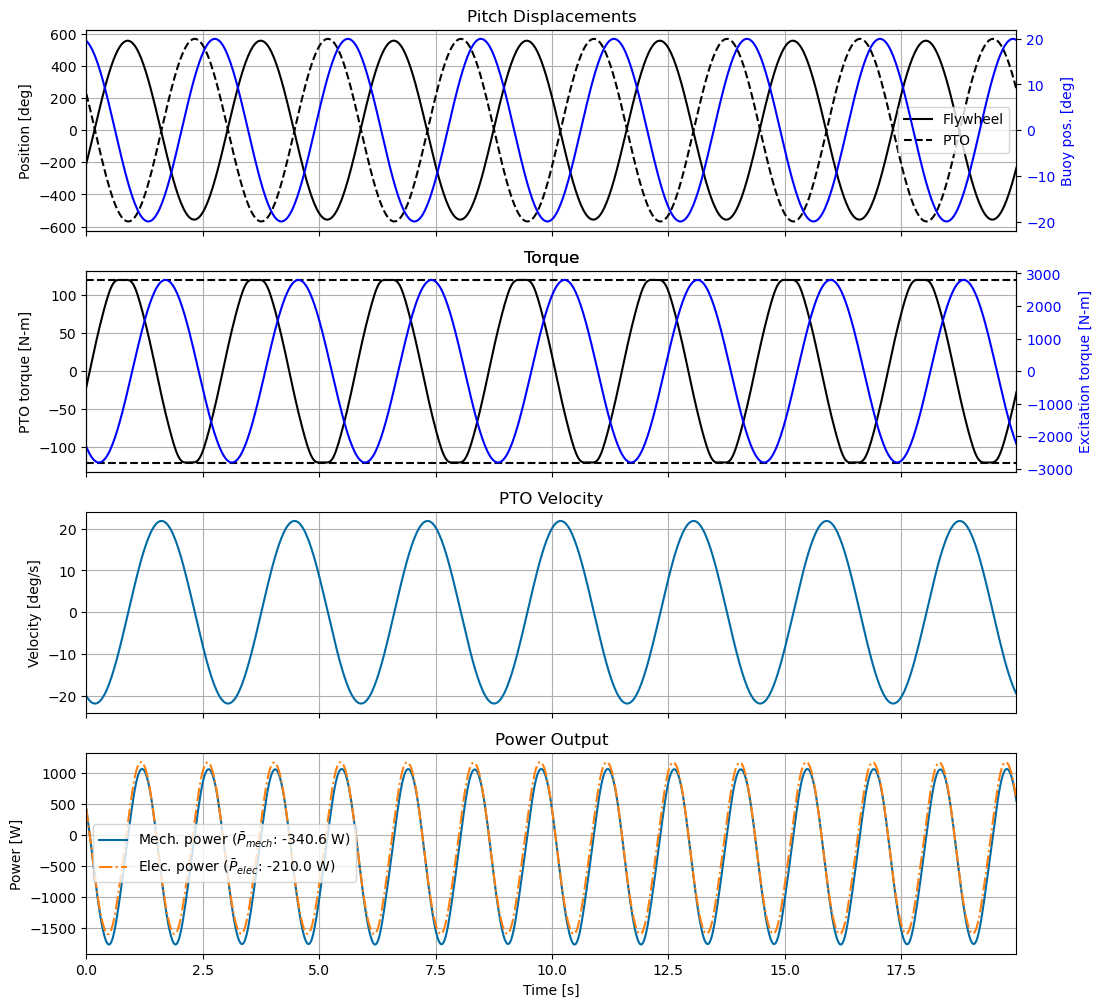

In [24]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom.time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom.pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 2.3 Sanky Diagram

## 3. Irregular wave